In [1]:
# ============================================================================
# ЭТАП 1: Подготовка окружения и загрузка данных
# ============================================================================

import os
import subprocess
import sys

print("Установка зависимостей...")

packages = [
    "pandas",
    "numpy",
    "scikit-learn",
    "transformers",
    "torch",
    "datasets",
    "tqdm",
    "matplotlib",
    "seaborn",
    "requests",
    "imbalanced-learn",
    "openpyxl",
]

for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("Все зависимости установлены")

# ============================================================================
# Импорты
# ============================================================================

import pandas as pd
import numpy as np
import re
import string
import pickle
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

print("\n Загрузка NLTK данных...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
print(" NLTK данные загружены")

# ============================================================================
# Загрузка ToxiCR датасета
# ============================================================================

print("\n Загрузка ToxiCR датасета...")

import urllib.request

url_excel = "https://github.com/WSU-SEAL/ToxiCR/raw/master/models/code-review-dataset-full.xlsx"
url_csv = "https://raw.githubusercontent.com/WSU-SEAL/ToxiCR/master/data/github_comments_labeled.csv"

df = None


print(" Попытка скачать Excel датасет...")
urllib.request.urlretrieve(url_excel, '/content/toxicr_dataset.xlsx')

print(" Чтение Excel файла...")
df = pd.read_excel('/content/toxicr_dataset.xlsx')
print(f" Excel датасет загружен: {df.shape[0]} записей, {df.shape[1]} столбцов")
print(f"\nКолонки в датасете: {list(df.columns)}")
print(f"\nПервые 3 строки:\n{df.head(3)}")



df.columns = df.columns.str.lower().str.strip()

comment_col = None
label_col = None

for col in df.columns:
    if 'comment' in col or 'text' in col or 'message' in col or 'review' in col:
        comment_col = col
        break

for col in df.columns:
    if 'toxic' in col or 'label' in col or 'class' in col or 'category' in col:
        label_col = col
        break

if not comment_col or not label_col:
    print(f"\n Не удалось автоматически определить колонки")
    print(f"Доступные колонки: {list(df.columns)}")

    if len(df.columns) >= 2:
        comment_col = df.columns[0]
        label_col = df.columns[1]
        print(f" Используются колонки по умолчанию: '{comment_col}' и '{label_col}'")

if comment_col and label_col:
    df = df[[comment_col, label_col]].copy()
    df.columns = ['comment', 'toxic']
    print(f"\n Используются колонки: '{comment_col}' (комментарий) и '{label_col}' (метка)")

print(f"\nРаспределение классов:\n{df['toxic'].value_counts()}")
print(f"\nПроцент токсичных: {df['toxic'].mean()*100:.2f}%")

# ============================================================================
# Статистика ДО очистки
# ============================================================================

print("\n" + "="*60)
print("СТАТИСТИКА ДО ОЧИСТКИ")
print("="*60)
print(f"Всего записей: {len(df)}")
print(f"Пропущенные значения: {df.isnull().sum().sum()}")
print(f"Дубликаты: {df.duplicated().sum()}")

stats_before = {
    "total_records": len(df),
    "missing_values": df.isnull().sum().sum(),
    "duplicates": df.duplicated().sum(),
}

# ============================================================================
# ОЧИСТКА ДАННЫХ
# ============================================================================

print("\n" + "="*60)
print("ОЧИСТКА ДАННЫХ")
print("="*60)

df = df.dropna()
print(f" После удаления пропусков: {len(df)} записей")

df = df.drop_duplicates()
print(f" После удаления дубликатов: {len(df)} записей")

df = df.reset_index(drop=True)

# ============================================================================
# ПРЕДОБРАБОТКА ТЕКСТА
# ============================================================================

print("\n" + "="*60)
print("ПРЕДОБРАБОТКА ТЕКСТА")
print("="*60)

def clean_text(text):
    """Комплексная очистка текста"""

    if not isinstance(text, str):
        return ""

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # писать словарь с offensive словами я не захотел, но так можно было бы повысить качество датасета
    contractions_dict = {
        "don't": "do not",
        "doesn't": "does not",
        "didn't": "did not",
        "won't": "will not",
        "wouldn't": "would not",
        "can't": "can not",
        "couldn't": "could not",
        "shouldn't": "should not",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not",
        "we're": "we are",
        "they're": "they are",
        "i'm": "i am",
        "you're": "you are",
        "it's": "it is",
        "that's": "that is",
        "what's": "what is",
        "who's": "who is",
        "where's": "where is",
        "when's": "when is",
        "why's": "why is",
        "how's": "how is",
        "i've": "i have",
        "you've": "you have",
        "we've": "we have",
        "they've": "they have",
        "i'll": "i will",
        "you'll": "you will",
        "he'll": "he will",
        "she'll": "she will",
        "it'll": "it will",
        "we'll": "we will",
        "they'll": "they will",
    }

    text_lower = text.lower()
    for contraction, expansion in contractions_dict.items():
        text_lower = text_lower.replace(contraction, expansion)

    text_lower = re.sub(r'(.)\1{2,}', r'\1', text_lower)

    text_lower = re.sub(r'[^a-z0-9\s]', '', text_lower)

    text_lower = ' '.join(text_lower.split())

    return text_lower

print("Применение функции очистки...")
df['comment_clean'] = df['comment'].apply(clean_text)

print("Предобработка текста завершена")
print(f"\nПримеры очищенного текста:")
for i in range(min(3, len(df))):
    print(f"  Оригинал: {df['comment'].iloc[i][:60]}...")
    print(f"  Очищено:  {df['comment_clean'].iloc[i][:60]}...")
    print()

# ============================================================================
# СТАТИСТИКА ПОСЛЕ ОЧИСТКИ
# ============================================================================

print("="*60)
print("СТАТИСТИКА ПОСЛЕ ОЧИСТКИ")
print("="*60)
print(f"Всего записей: {len(df)}")
print(f"Токсичных: {(df['toxic']==1).sum()} ({(df['toxic']==1).mean()*100:.2f}%)")
print(f"Нетоксичных: {(df['toxic']==0).sum()} ({(df['toxic']==0).mean()*100:.2f}%)")

stats_after = {
    "total_records": len(df),
    "toxic_count": int((df['toxic']==1).sum()),
    "non_toxic_count": int((df['toxic']==0).sum()),
    "toxic_percent": float((df['toxic']==1).mean()*100),
}

# ============================================================================
# Сохранение очищенных данных
# ============================================================================

print("\n Сохранение очищенных данных...")

df.to_csv('/content/toxicr_cleaned.csv', index=False)
print(" Сохранено: toxicr_cleaned.csv")

import json

stats_to_save = {
    "before_cleaning": {
        "total_records": int(stats_before["total_records"]),
        "missing_values": int(stats_before["missing_values"]),
        "duplicates": int(stats_before["duplicates"]),
    },
    "after_cleaning": {
        "total_records": int(stats_after["total_records"]),
        "toxic_count": int(stats_after["toxic_count"]),
        "non_toxic_count": int(stats_after["non_toxic_count"]),
        "toxic_percent": float(stats_after["toxic_percent"]),
    }
}

with open('/content/data_stats.json', 'w') as f:
    json.dump(stats_to_save, f, indent=2)

print(" Сохранено: data_stats.json")

print("\n" + "="*60)
print(" ЭТАП 1 ЗАВЕРШЕН - данные готовы к моделированию")
print("="*60)

print(f"\nДанные для следующих этапов:")
print(f"  - Всего примеров: {len(df)}")
print(f"  - Токсичных: {stats_after['toxic_count']}")
print(f"  - Нетоксичных: {stats_after['non_toxic_count']}")
print(f"  - Процент токсичных: {stats_after['toxic_percent']:.2f}%")


Установка зависимостей...
Все зависимости установлены

 Загрузка NLTK данных...
 NLTK данные загружены

 Загрузка ToxiCR датасета...
 Попытка скачать Excel датасет...
 Чтение Excel файла...
 Excel датасет загружен: 19651 записей, 2 столбцов

Колонки в датасете: ['message', 'is_toxic']

Первые 3 строки:
                                             message  is_toxic
0  This and below assignments also should be removed         0
1          this should be flavor_id = self.flavor_id         0
2                     bool session_adopted_ = false;         0

 Используются колонки: 'message' (комментарий) и 'is_toxic' (метка)

Распределение классов:
toxic
0    15894
1     3757
Name: count, dtype: int64

Процент токсичных: 19.12%

СТАТИСТИКА ДО ОЧИСТКИ
Всего записей: 19651
Пропущенные значения: 4
Дубликаты: 6746

ОЧИСТКА ДАННЫХ
 После удаления пропусков: 19647 записей
 После удаления дубликатов: 12904 записей

ПРЕДОБРАБОТКА ТЕКСТА
Применение функции очистки...
Предобработка текста завершена

При

ЭТАП 2: КЛАССИЧЕСКИЕ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ

 Загрузка очищенных данных...
Данные загружены: 12904 записей

 Фильтрация пустых строк...
   Удалено пустых записей: 2
   Осталось записей: 12902

 Распределение классов:
   Токсичных (1): 2522 (19.55%)
   Нетоксичных (0): 10380 (80.45%)

 Настройка векторизаторов...
Векторизаторы настроены:
   - CountVectorizer (max_features=5000, ngrams=(1,2))
   - TfidfVectorizer (max_features=5000, ngrams=(1,2))

 Настройка моделей...
 Модели настроены:
   - Logistic Regression (class_weight='balanced')
   - Random Forest (n_estimators=100, max_depth=20)

10-ФОЛДОВАЯ КРОСС-ВАЛИДАЦИЯ

 Модель 1/4: Logistic Regression + CountVectorizer
----------------------------------------------------------------------
Размерность признаков: (12902, 5000)
Результаты:
   Accuracy:  0.8931 ± 0.0093
   Precision: 0.7111 ± 0.0329
   Recall:    0.7612 ± 0.0250
   F1-Score:  0.7350 ± 0.0253
   ROC-AUC:   0.8992

 Модель 2/4: Logistic Regression + TF-IDF
------------------

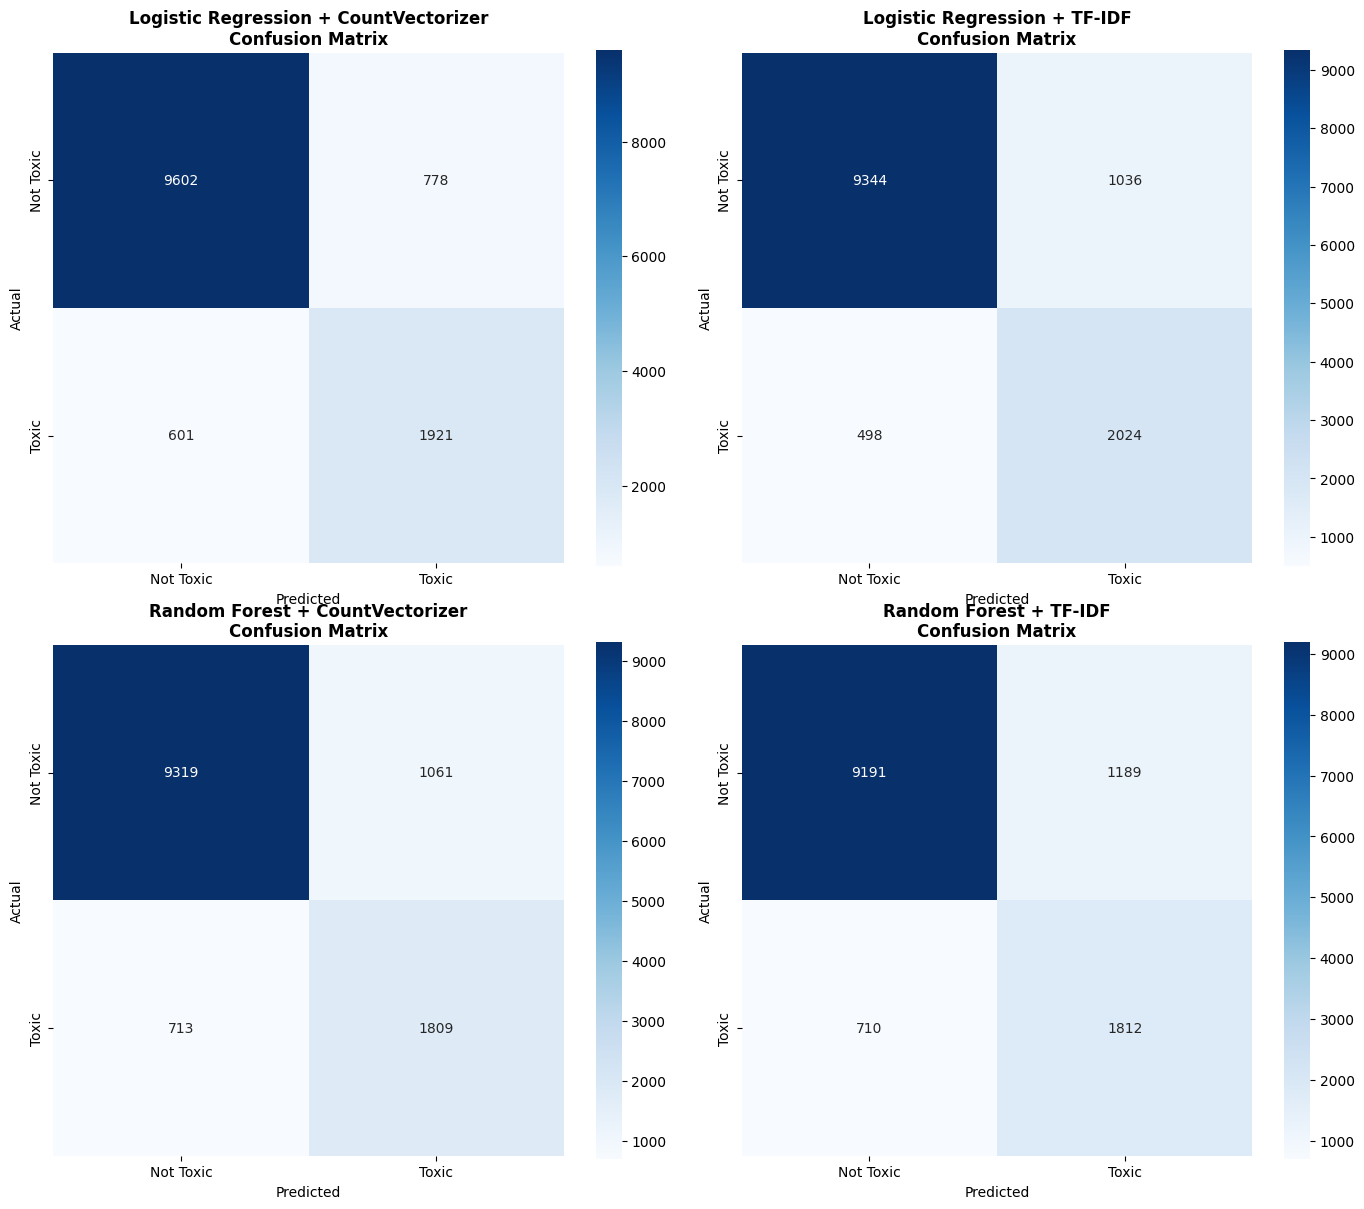


СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ

 Сохранено: classical_models_comparison.png


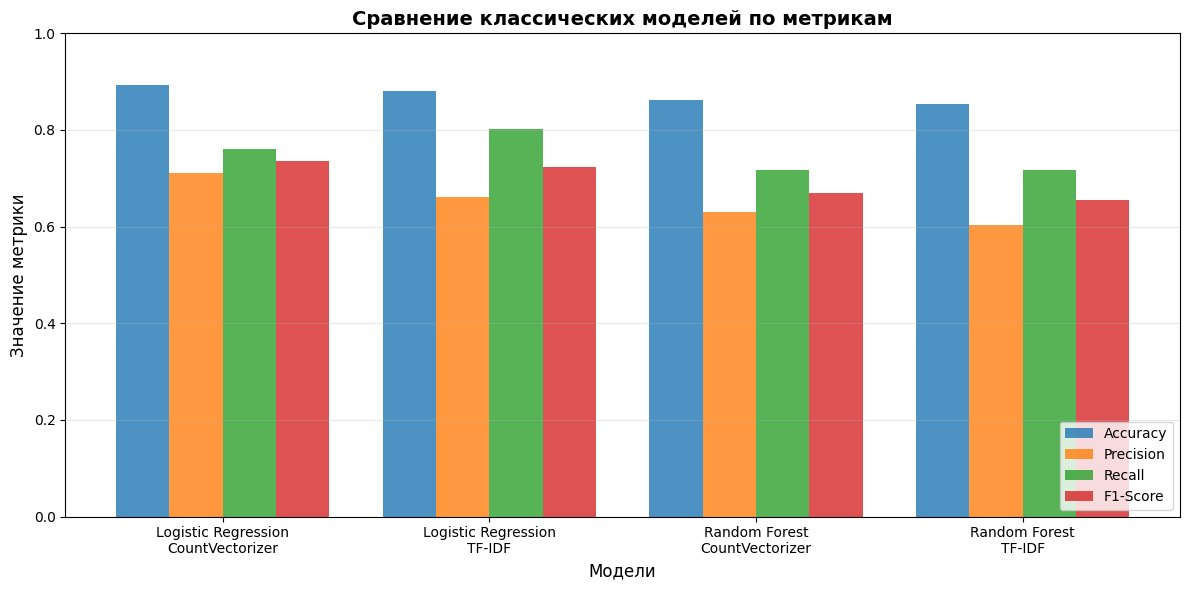

 Сохранено: radar_chart_classical.png


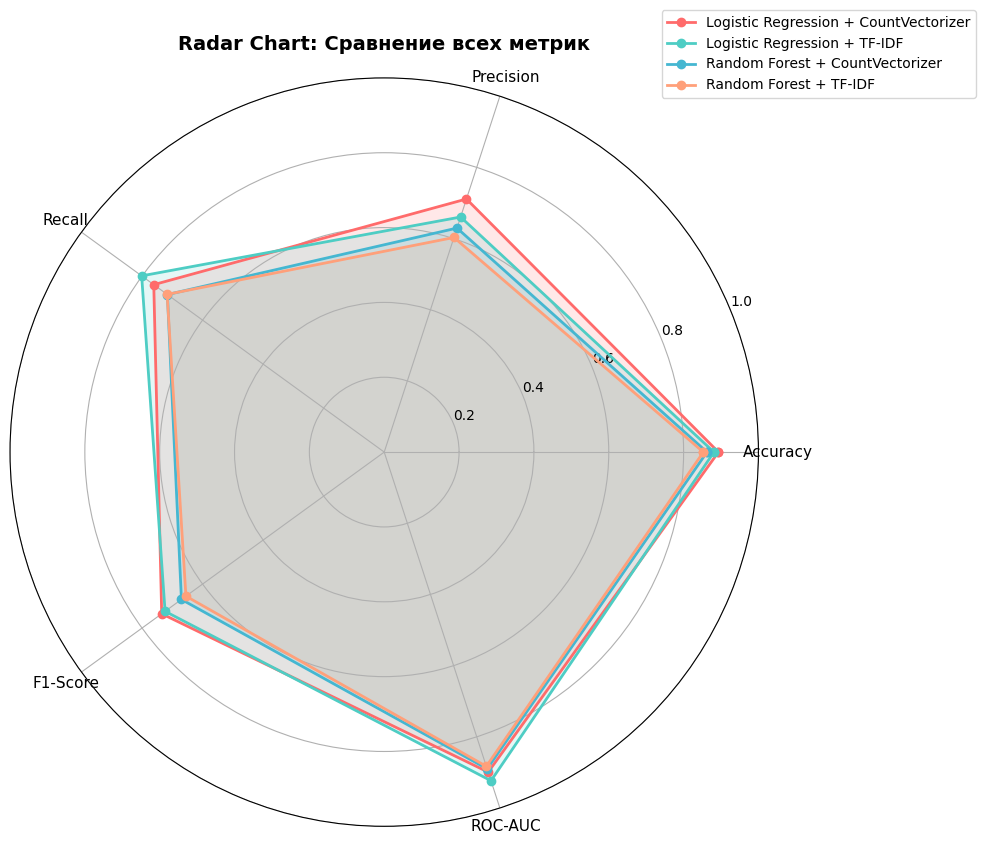


ЛУЧШАЯ МОДЕЛЬ

🏆 Лучшая модель по F1-Score: Logistic Regression + CountVectorizer

   Метрики:
   Accuracy:  0.8931 ± 0.0093
   Precision: 0.7111 ± 0.0329
   Recall:    0.7612 ± 0.0250
   F1-Score:  0.7350 ± 0.0253
   ROC-AUC:   0.8992

 ЭТАП 2 ЗАВЕРШЕН

 Созданные файлы:
   - classical_results.csv
   - confusion_matrices_classical.png
   - classical_models_comparison.png
   - radar_chart_classical.png


In [2]:

# ============================================================================
# ЭТАП 2: Классические модели машинного обучения
# ============================================================================
#
# Согласно требованиям:
# 1. Используются CountVectorizer и TfidfVectorizer
# 2. Обучаются Logistic Regression и Random Forest
# 3. 10-фолдовая кросс-валидация (KFold cross-validation)
# 4. Построение confusion matrix
# 5. Метрики: accuracy, precision, recall, f1-score
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("ЭТАП 2: КЛАССИЧЕСКИЕ МОДЕЛИ МАШИННОГО ОБУЧЕНИЯ")
print("="*70)

# ============================================================================
# Загрузка очищенных данных
# ============================================================================

print("\n Загрузка очищенных данных...")

try:
    df = pd.read_csv('/content/toxicr_cleaned.csv')
    print(f"Данные загружены: {len(df)} записей")

    print("\n Фильтрация пустых строк...")
    initial_count = len(df)

    df = df.dropna(subset=['comment_clean'])

    df = df[df['comment_clean'].str.strip() != '']

    df = df.reset_index(drop=True)

    filtered_count = initial_count - len(df)
    if filtered_count > 0:
        print(f"   Удалено пустых записей: {filtered_count}")
    print(f"   Осталось записей: {len(df)}")

    X = df['comment_clean'].values
    y = df['toxic'].values

    print(f"\n Распределение классов:")
    print(f"   Токсичных (1): {(y==1).sum()} ({(y==1).mean()*100:.2f}%)")
    print(f"   Нетоксичных (0): {(y==0).sum()} ({(y==0).mean()*100:.2f}%)")

    empty_count = sum([1 for text in X if not text or str(text).strip() == ''])
    if empty_count > 0:
        print(f"\n Обнаружено пустых строк: {empty_count}")
        mask = [bool(text and str(text).strip()) for text in X]
        X = X[mask]
        y = y[mask]
        print(f"   После фильтрации осталось: {len(X)} записей")

except FileNotFoundError:
    print("Файл toxicr_cleaned.csv не найден!")
    raise FileNotFoundError("Требуется файл toxicr_cleaned.csv")

# ============================================================================
# Настройка векторизаторов
# ============================================================================

print("\n Настройка векторизаторов...")

count_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # uni-grams и bi-grams
    min_df=2,            # минимум 2 появления
    max_df=0.9,          # максимум в 90% документов
)

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,   # логарифмическая нормализация
)

print("Векторизаторы настроены:")
print("   - CountVectorizer (max_features=5000, ngrams=(1,2))")
print("   - TfidfVectorizer (max_features=5000, ngrams=(1,2))")

# ============================================================================
# Настройка моделей
# ============================================================================

print("\n Настройка моделей...")

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Баланс классов
    random_state=42,
    solver='liblinear',
    C=1.0,
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Баланс классов
    random_state=42,
    n_jobs=-1,
)

print(" Модели настроены:")
print("   - Logistic Regression (class_weight='balanced')")
print("   - Random Forest (n_estimators=100, max_depth=20)")

# ============================================================================
# 10-фолдовая кросс-валидация
# ============================================================================

print("\n" + "="*70)
print("10-ФОЛДОВАЯ КРОСС-ВАЛИДАЦИЯ")
print("="*70)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

results = []

# ============================================================================
# Модель 1: Logistic Regression + CountVectorizer
# ============================================================================

print("\n Модель 1/4: Logistic Regression + CountVectorizer")
print("-" * 70)

X_count = count_vectorizer.fit_transform(X)
print(f"Размерность признаков: {X_count.shape}")

cv_results_lr_count = cross_validate(
    lr_model, X_count, y,
    cv=kfold,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

y_pred_lr_count = cross_val_predict(lr_model, X_count, y, cv=kfold, n_jobs=-1)

results.append({
    'Model': 'Logistic Regression + CountVectorizer',
    'Accuracy': cv_results_lr_count['test_accuracy'].mean(),
    'Accuracy_std': cv_results_lr_count['test_accuracy'].std(),
    'Precision': cv_results_lr_count['test_precision'].mean(),
    'Precision_std': cv_results_lr_count['test_precision'].std(),
    'Recall': cv_results_lr_count['test_recall'].mean(),
    'Recall_std': cv_results_lr_count['test_recall'].std(),
    'F1-Score': cv_results_lr_count['test_f1'].mean(),
    'F1_std': cv_results_lr_count['test_f1'].std(),
    'ROC-AUC': cv_results_lr_count['test_roc_auc'].mean(),
})

print(f"Результаты:")
print(f"   Accuracy:  {cv_results_lr_count['test_accuracy'].mean():.4f} ± {cv_results_lr_count['test_accuracy'].std():.4f}")
print(f"   Precision: {cv_results_lr_count['test_precision'].mean():.4f} ± {cv_results_lr_count['test_precision'].std():.4f}")
print(f"   Recall:    {cv_results_lr_count['test_recall'].mean():.4f} ± {cv_results_lr_count['test_recall'].std():.4f}")
print(f"   F1-Score:  {cv_results_lr_count['test_f1'].mean():.4f} ± {cv_results_lr_count['test_f1'].std():.4f}")
print(f"   ROC-AUC:   {cv_results_lr_count['test_roc_auc'].mean():.4f}")

# ============================================================================
# Модель 2: Logistic Regression + TF-IDF
# ============================================================================

print("\n Модель 2/4: Logistic Regression + TF-IDF")
print("-" * 70)

X_tfidf = tfidf_vectorizer.fit_transform(X)
print(f"Размерность признаков: {X_tfidf.shape}")

cv_results_lr_tfidf = cross_validate(
    lr_model, X_tfidf, y,
    cv=kfold,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

y_pred_lr_tfidf = cross_val_predict(lr_model, X_tfidf, y, cv=kfold, n_jobs=-1)

results.append({
    'Model': 'Logistic Regression + TF-IDF',
    'Accuracy': cv_results_lr_tfidf['test_accuracy'].mean(),
    'Accuracy_std': cv_results_lr_tfidf['test_accuracy'].std(),
    'Precision': cv_results_lr_tfidf['test_precision'].mean(),
    'Precision_std': cv_results_lr_tfidf['test_precision'].std(),
    'Recall': cv_results_lr_tfidf['test_recall'].mean(),
    'Recall_std': cv_results_lr_tfidf['test_recall'].std(),
    'F1-Score': cv_results_lr_tfidf['test_f1'].mean(),
    'F1_std': cv_results_lr_tfidf['test_f1'].std(),
    'ROC-AUC': cv_results_lr_tfidf['test_roc_auc'].mean(),
})

print(f" Результаты:")
print(f"   Accuracy:  {cv_results_lr_tfidf['test_accuracy'].mean():.4f} ± {cv_results_lr_tfidf['test_accuracy'].std():.4f}")
print(f"   Precision: {cv_results_lr_tfidf['test_precision'].mean():.4f} ± {cv_results_lr_tfidf['test_precision'].std():.4f}")
print(f"   Recall:    {cv_results_lr_tfidf['test_recall'].mean():.4f} ± {cv_results_lr_tfidf['test_recall'].std():.4f}")
print(f"   F1-Score:  {cv_results_lr_tfidf['test_f1'].mean():.4f} ± {cv_results_lr_tfidf['test_f1'].std():.4f}")
print(f"   ROC-AUC:   {cv_results_lr_tfidf['test_roc_auc'].mean():.4f}")

# ============================================================================
# Модель 3: Random Forest + CountVectorizer
# ============================================================================

print("\n Модель 3/4: Random Forest + CountVectorizer")
print("-" * 70)

cv_results_rf_count = cross_validate(
    rf_model, X_count, y,
    cv=kfold,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

y_pred_rf_count = cross_val_predict(rf_model, X_count, y, cv=kfold, n_jobs=-1)

results.append({
    'Model': 'Random Forest + CountVectorizer',
    'Accuracy': cv_results_rf_count['test_accuracy'].mean(),
    'Accuracy_std': cv_results_rf_count['test_accuracy'].std(),
    'Precision': cv_results_rf_count['test_precision'].mean(),
    'Precision_std': cv_results_rf_count['test_precision'].std(),
    'Recall': cv_results_rf_count['test_recall'].mean(),
    'Recall_std': cv_results_rf_count['test_recall'].std(),
    'F1-Score': cv_results_rf_count['test_f1'].mean(),
    'F1_std': cv_results_rf_count['test_f1'].std(),
    'ROC-AUC': cv_results_rf_count['test_roc_auc'].mean(),
})

print(f" Результаты:")
print(f"   Accuracy:  {cv_results_rf_count['test_accuracy'].mean():.4f} ± {cv_results_rf_count['test_accuracy'].std():.4f}")
print(f"   Precision: {cv_results_rf_count['test_precision'].mean():.4f} ± {cv_results_rf_count['test_precision'].std():.4f}")
print(f"   Recall:    {cv_results_rf_count['test_recall'].mean():.4f} ± {cv_results_rf_count['test_recall'].std():.4f}")
print(f"   F1-Score:  {cv_results_rf_count['test_f1'].mean():.4f} ± {cv_results_rf_count['test_f1'].std():.4f}")
print(f"   ROC-AUC:   {cv_results_rf_count['test_roc_auc'].mean():.4f}")

# ============================================================================
# Модель 4: Random Forest + TF-IDF
# ============================================================================

print("\n Модель 4/4: Random Forest + TF-IDF")
print("-" * 70)

cv_results_rf_tfidf = cross_validate(
    rf_model, X_tfidf, y,
    cv=kfold,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

y_pred_rf_tfidf = cross_val_predict(rf_model, X_tfidf, y, cv=kfold, n_jobs=-1)

results.append({
    'Model': 'Random Forest + TF-IDF',
    'Accuracy': cv_results_rf_tfidf['test_accuracy'].mean(),
    'Accuracy_std': cv_results_rf_tfidf['test_accuracy'].std(),
    'Precision': cv_results_rf_tfidf['test_precision'].mean(),
    'Precision_std': cv_results_rf_tfidf['test_precision'].std(),
    'Recall': cv_results_rf_tfidf['test_recall'].mean(),
    'Recall_std': cv_results_rf_tfidf['test_recall'].std(),
    'F1-Score': cv_results_rf_tfidf['test_f1'].mean(),
    'F1_std': cv_results_rf_tfidf['test_f1'].std(),
    'ROC-AUC': cv_results_rf_tfidf['test_roc_auc'].mean(),
})

print(f"Результаты:")
print(f"   Accuracy:  {cv_results_rf_tfidf['test_accuracy'].mean():.4f} ± {cv_results_rf_tfidf['test_accuracy'].std():.4f}")
print(f"   Precision: {cv_results_rf_tfidf['test_precision'].mean():.4f} ± {cv_results_rf_tfidf['test_precision'].std():.4f}")
print(f"   Recall:    {cv_results_rf_tfidf['test_recall'].mean():.4f} ± {cv_results_rf_tfidf['test_recall'].std():.4f}")
print(f"   F1-Score:  {cv_results_rf_tfidf['test_f1'].mean():.4f} ± {cv_results_rf_tfidf['test_f1'].std():.4f}")
print(f"   ROC-AUC:   {cv_results_rf_tfidf['test_roc_auc'].mean():.4f}")

# ============================================================================
# Сводная таблица результатов
# ============================================================================

print("\n" + "="*70)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*70 + "\n")

results_df = pd.DataFrame(results)
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))

results_df.to_csv('/content/classical_results.csv', index=False)
print("\n Сохранено: classical_results.csv")

# ============================================================================
# Построение Confusion Matrix
# ============================================================================

print("\n" + "="*70)
print("ПОСТРОЕНИЕ CONFUSION MATRIX")
print("="*70)

models_for_cm = [
    ('Logistic Regression + CountVectorizer', y_pred_lr_count),
    ('Logistic Regression + TF-IDF', y_pred_lr_tfidf),
    ('Random Forest + CountVectorizer', y_pred_rf_count),
    ('Random Forest + TF-IDF', y_pred_rf_tfidf),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (model_name, y_pred) in enumerate(models_for_cm):
    cm = confusion_matrix(y, y_pred)

    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Not Toxic', 'Toxic'],
        yticklabels=['Not Toxic', 'Toxic'],
        ax=axes[idx],
        cbar=True,
        square=True,
    )

    axes[idx].set_title(f'{model_name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual', fontsize=10)
    axes[idx].set_xlabel('Predicted', fontsize=10)

    tn, fp, fn, tp = cm.ravel()
    print(f"\n {model_name}:")
    print(f"   True Negatives (TN):  {tn}")
    print(f"   False Positives (FP): {fp}")
    print(f"   False Negatives (FN): {fn}")
    print(f"   True Positives (TP):  {tp}")

plt.tight_layout()
plt.savefig('/content/confusion_matrices_classical.png', dpi=150, bbox_inches='tight')
print("\n Сохранено: confusion_matrices_classical.png")
plt.show()

# ============================================================================
# Сравнительная визуализация моделей
# ============================================================================

print("\n" + "="*70)
print("СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ")
print("="*70)

fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, results_df[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('Модели', fontsize=12)
ax.set_ylabel('Значение метрики', fontsize=12)
ax.set_title('Сравнение классических моделей по метрикам', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([m.replace(' + ', '\n') for m in results_df['Model']], rotation=0, ha='center')
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig('/content/classical_models_comparison.png', dpi=150, bbox_inches='tight')
print("\n Сохранено: classical_models_comparison.png")
plt.show()

from math import pi

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, row in results_df.iterrows():
    values = [row[cat] for cat in categories]
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_title('Radar Chart: Сравнение всех метрик', size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig('/content/radar_chart_classical.png', dpi=150, bbox_inches='tight')
print(" Сохранено: radar_chart_classical.png")
plt.show()

# ============================================================================
# Лучшая модель
# ============================================================================

print("\n" + "="*70)
print("ЛУЧШАЯ МОДЕЛЬ")
print("="*70)

best_f1_idx = results_df['F1-Score'].idxmax()
best_model = results_df.iloc[best_f1_idx]

print(f"\n🏆 Лучшая модель по F1-Score: {best_model['Model']}")
print(f"\n   Метрики:")
print(f"   Accuracy:  {best_model['Accuracy']:.4f} ± {best_model['Accuracy_std']:.4f}")
print(f"   Precision: {best_model['Precision']:.4f} ± {best_model['Precision_std']:.4f}")
print(f"   Recall:    {best_model['Recall']:.4f} ± {best_model['Recall_std']:.4f}")
print(f"   F1-Score:  {best_model['F1-Score']:.4f} ± {best_model['F1_std']:.4f}")
print(f"   ROC-AUC:   {best_model['ROC-AUC']:.4f}")

# ============================================================================
# Завершение
# ============================================================================

print("\n" + "="*70)
print(" ЭТАП 2 ЗАВЕРШЕН")
print("="*70)

print("\n Созданные файлы:")
print("   - classical_results.csv")
print("   - confusion_matrices_classical.png")
print("   - classical_models_comparison.png")
print("   - radar_chart_classical.png")


ЭТАП 3: ТРАНСФОРМЕРЫ (RoBERTa и CodeBERT)

  Используемое устройство: CUDA
   GPU: Tesla T4
   Память GPU: 14.74 GB

 Загрузка очищенных данных...
 Данные загружены: 12904 записей
   После фильтрации: 12902 записей

 Подготовка данных...

 Разбиение данных:
   Train: 10321 записей
   Test:  2581 записей
   Train токсичных: 2017 (19.54%)
   Test токсичных:  505 (19.57%)


МОДЕЛЬ 1: RoBERTa


ОБУЧЕНИЕ: RoBERTa

 Загрузка roberta-base...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Модель и токенизатор загружены

🔄 Токенизация данных...
 Датасеты созданы

 Начало обучения (2 эпох)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.295100,0.278963,0.898876,0.704698,0.831683,0.762943
2,0.243400,0.255653,0.919799,0.815678,0.762376,0.788127



 Обучение завершено!
   Время обучения: 246.96 сек

 Оценка на тестовой выборке...



 Результаты:
   Accuracy:  0.9198
   Precision: 0.8157
   Recall:    0.7624
   F1-Score:  0.7881

 Получение предсказаний...


МОДЕЛЬ 2: CodeBERT


ОБУЧЕНИЕ: CodeBERT

 Загрузка microsoft/codebert-base...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Модель и токенизатор загружены

🔄 Токенизация данных...
 Датасеты созданы

 Начало обучения (2 эпох)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.265100,0.246093,0.916699,0.807203,0.754455,0.779939
2,0.213400,0.242981,0.922898,0.822785,0.772277,0.796731



 Обучение завершено!
   Время обучения: 304.99 сек

 Оценка на тестовой выборке...



 Результаты:
   Accuracy:  0.9229
   Precision: 0.8228
   Recall:    0.7723
   F1-Score:  0.7967

 Получение предсказаний...

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ТРАНСФОРМЕРОВ

   Model  Accuracy  Precision   Recall  F1-Score
 RoBERTa  0.919799   0.815678 0.762376  0.788127
CodeBERT  0.922898   0.822785 0.772277  0.796731

 Сохранено: transformers_results.csv

CONFUSION MATRIX ДЛЯ ТРАНСФОРМЕРОВ

 RoBERTa:
   True Negatives (TN):  1989
   False Positives (FP): 87
   False Negatives (FN): 120
   True Positives (TP):  385

 CodeBERT:
   True Negatives (TN):  1992
   False Positives (FP): 84
   False Negatives (FN): 115
   True Positives (TP):  390

 Сохранено: confusion_matrices_transformers.png


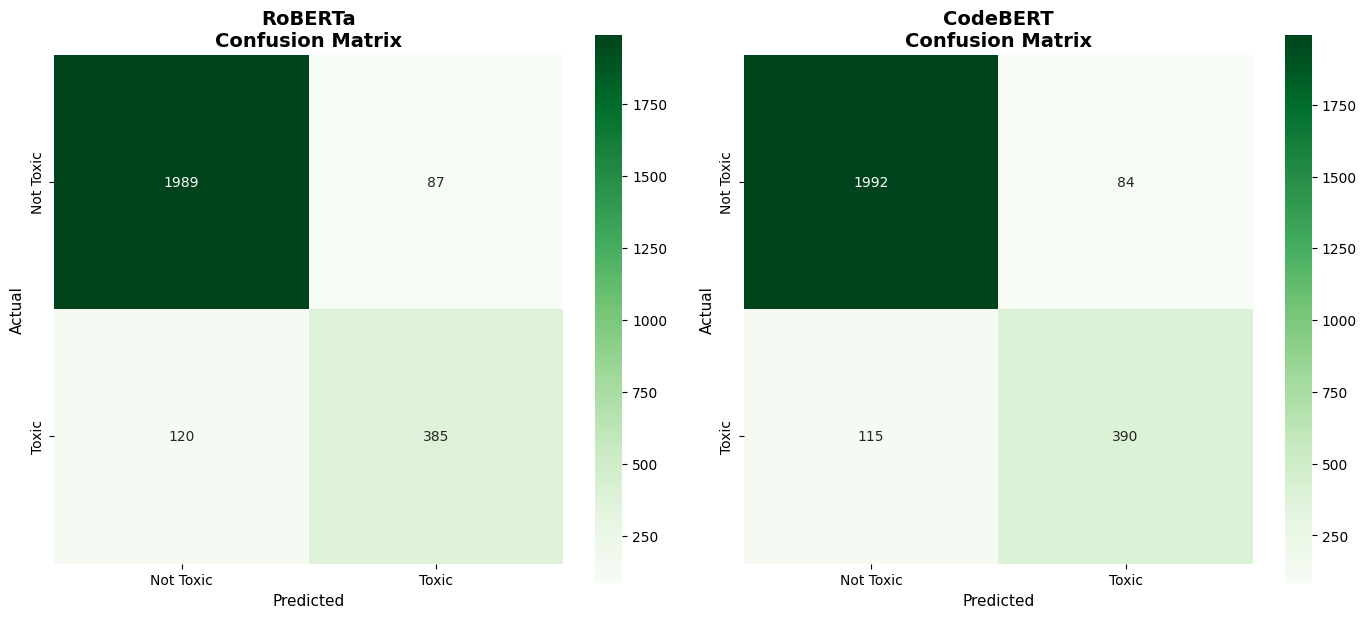


СРАВНЕНИЕ ТРАНСФОРМЕРОВ

 Сохранено: transformers_comparison.png


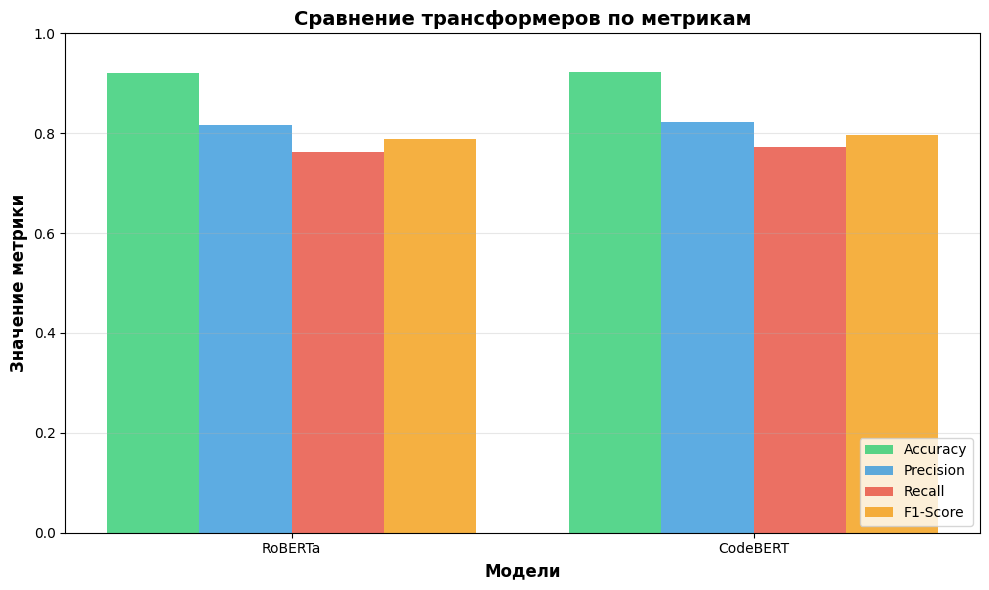


ЛУЧШАЯ МОДЕЛЬ СРЕДИ ТРАНСФОРМЕРОВ

 Лучшая модель: CodeBERT

   Метрики:
   Accuracy:  0.9229
   Precision: 0.8228
   Recall:    0.7723
   F1-Score:  0.7967

СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ

 Все модели:
                                Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression + CountVectorizer  0.893118   0.711139 0.761221  0.735023
         Logistic Regression + TF-IDF  0.881104   0.660540 0.801207  0.723918
      Random Forest + CountVectorizer  0.862503   0.629481 0.716169  0.669851
               Random Forest + TF-IDF  0.852813   0.603073 0.717116  0.654993
                              RoBERTa  0.919799   0.815678 0.762376  0.788127
                             CodeBERT  0.922898   0.822785 0.772277  0.796731

 Сохранено: all_models_results.csv
 Сохранено: all_models_comparison.png


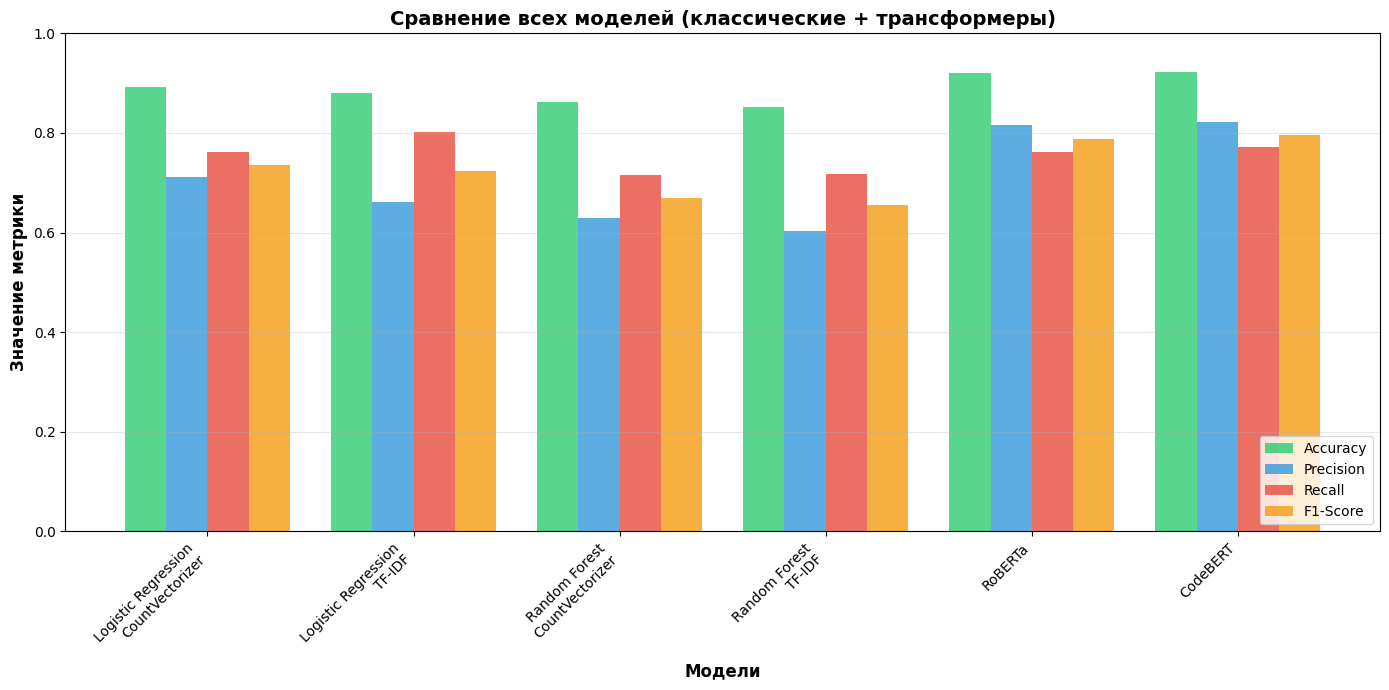


 ЛУЧШАЯ МОДЕЛЬ СРЕДИ ВСЕХ: CodeBERT
   F1-Score: 0.7967


In [4]:

# ============================================================================
# ЭТАП 3: Трансформеры (RoBERTa и CodeBERT)
# ============================================================================
#
# Согласно требованиям:
# 1. Fine-tuning RoBERTa и CodeBERT
# 2. Использование AutoModelForSequenceClassification и Trainer
# 3. Метрики: accuracy, precision, recall, f1-score
# 4. Обучение 1-2 эпохи
# 5. Train/test split (вместо 10-fold CV для экономии ресурсов)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("ЭТАП 3: ТРАНСФОРМЕРЫ (RoBERTa и CodeBERT)")
print("="*70)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n  Используемое устройство: {device.upper()}")
if device == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# ============================================================================
# Загрузка очищенных данных
# ============================================================================

print("\n Загрузка очищенных данных...")

try:
    df = pd.read_csv('/content/toxicr_cleaned.csv')
    print(f" Данные загружены: {len(df)} записей")

    # Фильтрация пустых строк
    df = df.dropna(subset=['comment_clean'])
    df = df[df['comment_clean'].str.strip() != '']
    df = df.reset_index(drop=True)

    print(f"   После фильтрации: {len(df)} записей")

except FileNotFoundError:
    print(" Файл toxicr_cleaned.csv не найден!")
    print("\n Запустите сначала: 01_setup_data_xlsx.py")
    raise FileNotFoundError("Требуется файл toxicr_cleaned.csv")

# ============================================================================
# Подготовка данных для трансформеров
# ============================================================================

print("\n Подготовка данных...")

# Train/test split (80/20) со стратификацией
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['comment_clean'].tolist(),
    df['toxic'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['toxic'],
)

print(f"\n Разбиение данных:")
print(f"   Train: {len(train_texts)} записей")
print(f"   Test:  {len(test_texts)} записей")
print(f"   Train токсичных: {sum(train_labels)} ({sum(train_labels)/len(train_labels)*100:.2f}%)")
print(f"   Test токсичных:  {sum(test_labels)} ({sum(test_labels)/len(test_labels)*100:.2f}%)")

# ============================================================================
# Функция для вычисления метрик
# ============================================================================

def compute_metrics(eval_pred):
    """Вычисление метрик для Trainer"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# ============================================================================
# Функция для обучения трансформера
# ============================================================================

def train_transformer(model_name, model_display_name, train_texts, train_labels,
                      test_texts, test_labels, num_epochs=2, batch_size=16):
    """
    Обучение трансформера

    Args:
        model_name: имя модели на HuggingFace
        model_display_name: отображаемое имя для результатов
        train_texts, train_labels: обучающие данные
        test_texts, test_labels: тестовые данные
        num_epochs: количество эпох
        batch_size: размер батча
    """

    print(f"\n{'='*70}")
    print(f"ОБУЧЕНИЕ: {model_display_name}")
    print(f"{'='*70}")

    print(f"\n Загрузка {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes=True,
    )

    print(f" Модель и токенизатор загружены")

    print(f"\n🔄 Токенизация данных...")
    train_encodings = tokenizer(
        train_texts,
        truncation=True,
        padding=True,
        max_length=128,
    )

    test_encodings = tokenizer(
        test_texts,
        truncation=True,
        padding=True,
        max_length=128,
    )

    train_dataset = Dataset.from_dict({
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'labels': train_labels,
    })

    test_dataset = Dataset.from_dict({
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'labels': test_labels,
    })

    print(f" Датасеты созданы")

    training_args = TrainingArguments(
        output_dir=f'/content/{model_display_name.replace(" ", "_")}_results',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f'/content/{model_display_name.replace(" ", "_")}_logs',
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=1,
        report_to=None,
        fp16=(device == "cuda"),
        push_to_hub=False,
        disable_tqdm=False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    print(f"\n Начало обучения ({num_epochs} эпох)...")
    train_result = trainer.train()

    print(f"\n Обучение завершено!")
    print(f"   Время обучения: {train_result.metrics['train_runtime']:.2f} сек")

    print(f"\n Оценка на тестовой выборке...")
    eval_results = trainer.evaluate()

    print(f"\n Результаты:")
    print(f"   Accuracy:  {eval_results['eval_accuracy']:.4f}")
    print(f"   Precision: {eval_results['eval_precision']:.4f}")
    print(f"   Recall:    {eval_results['eval_recall']:.4f}")
    print(f"   F1-Score:  {eval_results['eval_f1']:.4f}")

    print(f"\n Получение предсказаний...")
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    return {
        'model_name': model_display_name,
        'accuracy': eval_results['eval_accuracy'],
        'precision': eval_results['eval_precision'],
        'recall': eval_results['eval_recall'],
        'f1': eval_results['eval_f1'],
        'y_pred': y_pred,
        'trainer': trainer,
    }

# ============================================================================
# Обучение RoBERTa
# ============================================================================

print("\n" + "="*35)
print("\nМОДЕЛЬ 1: RoBERTa")
print("\n" + "="*35)

roberta_results = train_transformer(
    model_name='roberta-base',
    model_display_name='RoBERTa',
    train_texts=train_texts,
    train_labels=train_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    num_epochs=2,
    batch_size=16,
)

# ============================================================================
# Обучение CodeBERT
# ============================================================================

print("\n" + "="*35)
print("\nМОДЕЛЬ 2: CodeBERT")
print("\n" + "="*35)

codebert_results = train_transformer(
    model_name='microsoft/codebert-base',
    model_display_name='CodeBERT',
    train_texts=train_texts,
    train_labels=train_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    num_epochs=2,
    batch_size=16,
)

# ============================================================================
# Сводная таблица результатов
# ============================================================================

print("\n" + "="*70)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ТРАНСФОРМЕРОВ")
print("="*70 + "\n")

transformer_results = pd.DataFrame([
    {
        'Model': roberta_results['model_name'],
        'Accuracy': roberta_results['accuracy'],
        'Precision': roberta_results['precision'],
        'Recall': roberta_results['recall'],
        'F1-Score': roberta_results['f1'],
    },
    {
        'Model': codebert_results['model_name'],
        'Accuracy': codebert_results['accuracy'],
        'Precision': codebert_results['precision'],
        'Recall': codebert_results['recall'],
        'F1-Score': codebert_results['f1'],
    }
])

print(transformer_results.to_string(index=False))

transformer_results.to_csv('/content/transformers_results.csv', index=False)
print("\n Сохранено: transformers_results.csv")

# ============================================================================
# Построение Confusion Matrix
# ============================================================================

print("\n" + "="*70)
print("CONFUSION MATRIX ДЛЯ ТРАНСФОРМЕРОВ")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (results, ax) in enumerate([
    (roberta_results, axes[0]),
    (codebert_results, axes[1])
]):
    cm = confusion_matrix(test_labels, results['y_pred'])

    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Greens',
        xticklabels=['Not Toxic', 'Toxic'],
        yticklabels=['Not Toxic', 'Toxic'],
        ax=ax,
        cbar=True,
        square=True,
    )

    ax.set_title(f'{results["model_name"]}\nConfusion Matrix',
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_xlabel('Predicted', fontsize=11)

    tn, fp, fn, tp = cm.ravel()
    print(f"\n {results['model_name']}:")
    print(f"   True Negatives (TN):  {tn}")
    print(f"   False Positives (FP): {fp}")
    print(f"   False Negatives (FN): {fn}")
    print(f"   True Positives (TP):  {tp}")

plt.tight_layout()
plt.savefig('/content/confusion_matrices_transformers.png', dpi=150, bbox_inches='tight')
print("\n Сохранено: confusion_matrices_transformers.png")
plt.show()

# ============================================================================
# Сравнение трансформеров
# ============================================================================

print("\n" + "="*70)
print("СРАВНЕНИЕ ТРАНСФОРМЕРОВ")
print("="*70)

fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(transformer_results))
width = 0.2

colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, transformer_results[metric], width,
           label=metric, alpha=0.8, color=colors[i])

ax.set_xlabel('Модели', fontsize=12, fontweight='bold')
ax.set_ylabel('Значение метрики', fontsize=12, fontweight='bold')
ax.set_title('Сравнение трансформеров по метрикам',
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(transformer_results['Model'])
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig('/content/transformers_comparison.png', dpi=150, bbox_inches='tight')
print("\n Сохранено: transformers_comparison.png")
plt.show()

# ============================================================================
# Лучшая модель среди трансформеров
# ============================================================================

print("\n" + "="*70)
print("ЛУЧШАЯ МОДЕЛЬ СРЕДИ ТРАНСФОРМЕРОВ")
print("="*70)

best_idx = transformer_results['F1-Score'].idxmax()
best_transformer = transformer_results.iloc[best_idx]

print(f"\n Лучшая модель: {best_transformer['Model']}")
print(f"\n   Метрики:")
print(f"   Accuracy:  {best_transformer['Accuracy']:.4f}")
print(f"   Precision: {best_transformer['Precision']:.4f}")
print(f"   Recall:    {best_transformer['Recall']:.4f}")
print(f"   F1-Score:  {best_transformer['F1-Score']:.4f}")

# ============================================================================
# Сравнение с классическими моделями
# ============================================================================

print("\n" + "="*70)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*70)

try:
    classical_results = pd.read_csv('/content/classical_results.csv')

    all_results = pd.concat([
        classical_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']],
        transformer_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]
    ], ignore_index=True)

    print("\n Все модели:")
    print(all_results.to_string(index=False))

    all_results.to_csv('/content/all_models_results.csv', index=False)
    print("\n Сохранено: all_models_results.csv")

    fig, ax = plt.subplots(figsize=(14, 7))

    x = np.arange(len(all_results))
    width = 0.2

    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, all_results[metric], width,
               label=metric, alpha=0.8, color=colors[i])

    ax.set_xlabel('Модели', fontsize=12, fontweight='bold')
    ax.set_ylabel('Значение метрики', fontsize=12, fontweight='bold')
    ax.set_title('Сравнение всех моделей (классические + трансформеры)',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels([m.replace(' + ', '\n') for m in all_results['Model']],
                       rotation=45, ha='right')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.0)

    plt.tight_layout()
    plt.savefig('/content/all_models_comparison.png', dpi=150, bbox_inches='tight')
    print(" Сохранено: all_models_comparison.png")
    plt.show()

    best_overall_idx = all_results['F1-Score'].idxmax()
    best_overall = all_results.iloc[best_overall_idx]

    print(f"\n ЛУЧШАЯ МОДЕЛЬ СРЕДИ ВСЕХ: {best_overall['Model']}")
    print(f"   F1-Score: {best_overall['F1-Score']:.4f}")

except FileNotFoundError:
    print("\n Файл classical_results.csv не найден")
